# Reinforcement Learning Tutorial for POMDPs.jl

*inspired from Stanford Reinforcement Learning class*

## Dependencies
You need to install a few modules in order to use this notebook. If you have all the modules below installed, great! If not run the following commands:

In [ ]:
# install the POMDPs.jl interface
Pkg.add("POMDPs")

using POMDPs

# install the Tabular TD Learning solver
POMDPs.add("TabularTDLearning") 

# install a helper module
POMDPs.add("POMDPToolbox") # this provides support tools for simulations

If you already have all of the modules above, make sure you have the most recent versions. Many of these are still under heavy development, so update before starting by running

```julia
Pkg.update()
```

In [1]:
# first import the POMDPs.jl interface
using POMDPs

## Problem overview

### Mars Exploration


Let's consider a 1D gridworld and 2 different rewards at each extremities. 

![wall-e-mdp](initial_state.png)

The environment can be modeled as follow

- 10 states: 1,2,3,4,5,6,7,8,9,10
- 2 actions: left, right
- one episode lasts until a reward is found
- there is a reward of +1 in state 1 (Eve) and +2 in state 10 (the plant)
- Wall-E starts at 3

# Implementation

Let's start by defining a type containing all the problem parameters. In Reinforcement Learning, problems are usually framed as Markov decision processes (MDP). Our new problem must then be defined as a subtype of the abstract type `MDP{S,A}` where `S`and `A` are the state type and the action type respectively.
For more information about MDPs please refer to this [MDP tutorial](http://nbviewer.jupyter.org/github/sisl/POMDPs.jl/blob/master/examples/GridWorld.ipynb).

In [2]:
mutable struct MarsExp <: MDP{Int64, Symbol}
    r_left::Float64
    r_right::Float64
    start::Int64
    γ::Float64
    MarsExp(;r_left::Float64 = 1., r_right::Float64 = 10.,start::Int64 = 5, γ::Float64 = 0.5) = new(r_left, r_right, start, γ)
end

**State Space**

In this tutorial we consider a discrete environment. We can enumerate all the states and provide an indexing function.

In [3]:
function POMDPs.states(mdp::MarsExp)
    return 1:1:10
end
POMDPs.state_index(mdp::MarsExp, s::Int64) = s
POMDPs.n_states(mdp::MarsExp) = 10

**Action Space**

The action space is discrete and consists of only two actions: moving left or right. Again, we can enumerate and index the actions.

In [4]:
function POMDPs.actions(mdp::MarsExp)
    return [:left, :right]
end
POMDPs.action_index(mdp::MarsExp, a::Symbol) = a == :left ? 1 : 2
POMDPs.n_actions(mdp::MarsExp) = 2

**Generative Model**

In Reinforcement Learning problems, we do not assume prior knowledge on the environment. The agent learns the policy as it interacts with the environment. As a consequence all we need to provide is a generative model that allows to transition from one state to another. In addition we must define a reward function.

In [5]:
function POMDPs.generate_s(mdp::MarsExp, s::Int64, a::Symbol, rng::AbstractRNG)
    if a == :left
        return max(1, s-1)
    elseif a == :right
        return min(10, s+1)
    end
end
function POMDPs.reward(mdp::MarsExp, s::Int64, a::Symbol, sp::Int64)
    if sp == 1
        return mdp.r_left
    elseif sp == 10
        return mdp.r_right
    else
        return 0.0
    end
end     

**Note:** Instead of defining `generate_s`and `reward`, you can also define the function `generate_sr` that returns a tuple (next state, reward).

**Initial states**

In the proposed problem, the agent always arrives in the world at the state specified in the MDP type.

In [6]:
function POMDPs.initial_state(mdp::MarsExp, rng::AbstractRNG)
    return mdp.start 
end

**Terminal states**

Once a reward is found, the game is over.

In [7]:
function POMDPs.isterminal(mdp::MarsExp, s::Int64)
    return s == 1 || s == 10
end

**Discount Factor**

The reward received is discounted by a multiplicative factor. 

In [8]:
POMDPs.discount(mdp::MarsExp) = mdp.γ

## Initialize the problem

Let's generate an instance of the exploration problem. Here we set the start state on cell 4. Feel free to change this value as well as the rewards and the discount factor.

In [9]:
mdp = MarsExp(start=4, γ=0.9) 

MarsExp(1.0, 10.0, 4, 0.9)

## Solve with Q-learning

To solve the problem we can use the `TabularTDLearning` package which provides three model-free learning algorithms:
- Q Learning
- SARSA
- SARSA $\lambda$


All the solvers requires to specify an exploration strategy. Some common strategies like epsilon greedy are implemented in th `POMDPToolbox` package.

In [11]:
using TabularTDLearning, POMDPToolbox

INFO: Recompiling stale cache file C:\Users\Maxime\.julia\lib\v0.6\POMDPToolbox.ji for module POMDPToolbox.


Let's check that we implemented all the functions required by the QLearning solver. This can be done via the `@requirements_info` macro. 

In [12]:
@requirements_info QLearningSolver(MarsExp()) MarsExp()


INFO: POMDPs.jl requirements for solve(::QLearningSolver, ::Union{POMDPs.MDP,POMDPs.POMDP}) and dependencies. ([✔] = implemented correctly; [X] = missing)

For solve(::QLearningSolver, ::Union{POMDPs.MDP,POMDPs.POMDP}):
  [✔] initial_state(::MarsExp, ::AbstractRNG)
  [✔] generate_sr(::MarsExp, ::Int64, ::Symbol, ::AbstractRNG)
  [✔] state_index(::MarsExp, ::Int64)
  [✔] n_states(::MarsExp)
  [✔] n_actions(::MarsExp)
  [✔] action_index(::MarsExp, ::Symbol)
  [✔] discount(::MarsExp)



true

**Initialize the solver**

Use the keywords arguments to set the desired hyperparameters. 

**Tip:** run `?QLearningSolver` to toggle the documentation and have a list of all the hyper-parameters and their default value.

In [13]:
solver = QLearningSolver(mdp, learning_rate=0.1, n_episodes=100, max_episode_length=50, eval_every=50, n_eval_traj=100, 
                         exp_policy = EpsGreedyPolicy(mdp, 0.9));

We are now ready to solve for the optimal policy!

In [14]:
policy = solve(solver, mdp)

On Iteration 50, Returns: 0.8100000000000012
On Iteration 100, Returns: 5.904899999999999


POMDPToolbox.ValuePolicy{Any}(MarsExp(1.0, 10.0, 4, 0.9), [0.0 0.0; 0.997261 2.63477; … ; 5.45566 9.88027; 0.0 0.0], Any[:left, :right])

## Visualize the policy

We provided some rendering functions to visualize the policy of the exploration problem. 


*You need two packages for this: [Cairo](https://github.com/JuliaGraphics/Cairo.jl) and [Colors](https://github.com/JuliaGraphics/Colors.jl), they can be easily installed using `Pkg.add`.*

In [ ]:
Pkg.add("Cairo")
Pkg.add("Colors")

In [15]:
include("render.jl")

render_policy (generic function with 1 method)

The arrow represents the action to take and the number is the value associated to the state

**Note:** The value of the terminal state is zero. 

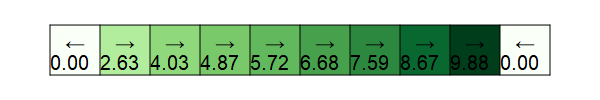

In [16]:
render_policy(policy)

## Evaluate the policy
Using the simulator from POMDPToolbox you can run many simulations to evaluate the learned policy. The `RolloutSimulator` type provides a fast simulator that will return the total discounted reward.

In [17]:
rng = MersenneTwister(9)
sim = RolloutSimulator(rng = rng, max_steps=10);
n_episodes = 100

100

In [18]:
qlearning_rewards = zeros(n_episodes)
for ep in 1:n_episodes
    r_tot = simulate(sim, mdp, policy)
    qlearning_rewards[ep] = r_tot
end
@printf("Performance of the Q learning policy: %2.2f ± %2.2f", mean(qlearning_rewards), std(qlearning_rewards))    

Performance of the Q learning policy: 5.90 ± 0.00

Let's compare it to a random policy. 

In [19]:
random_policy = RandomPolicy(mdp);

In [21]:
random_rewards = zeros(n_episodes)
for ep in 1:n_episodes
    r_tot = simulate(sim, mdp, random_policy)
    random_rewards[ep] = r_tot
end
@printf("Performance of the random policy: %2.2f ± %2.2f", mean(random_rewards), std(random_rewards))    

Performance of the random policy: 0.68 ± 1.42

**Try the following experiments:**

- Vary the discount factor and visualize the policy.
- Change the exploration parameters in the epsilon greedy policy.